In [1]:
# =====================================================
# IDENTIFICADOR DE TENIS VERDE OLIVA ("green_SB")
# =====================================================

import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# =====================================================
# 1. CONFIGURACIÓN INICIAL
# =====================================================

# Carpeta base con las imágenes del tenis
base_dir = "green_SB"

# Cargar modelo preentrenado (sin capa final)
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# =====================================================
# 2. FUNCIONES AUXILIARES
# =====================================================

def extraer_features(img_path):
    """Extrae las características de forma/textura usando MobileNetV2"""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    """Calcula el color promedio RGB de la imagen"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean_color = img.mean(axis=(0,1))  # (R, G, B)
    return mean_color

# =====================================================
# 3. EXTRAER Y GUARDAR LAS CARACTERÍSTICAS BASE
# =====================================================

features = []
colors = []
filenames = []

for fname in os.listdir(base_dir):
    if fname.lower().endswith(".jpg"):
        path = os.path.join(base_dir, fname)
        feat = extraer_features(path)
        col = promedio_color(path)
        features.append(feat)
        colors.append(col)
        filenames.append(fname)

features = np.array(features)
colors = np.array(colors)

np.save("greenSB_features.npy", features)
np.save("greenSB_colors.npy", colors)
np.save("greenSB_filenames.npy", filenames)

print(f"✅ Se procesaron {len(filenames)} imágenes del tenis base.")

# =====================================================
# 4. CONSULTAR UNA NUEVA IMAGEN
# =====================================================

def identificar_tenis(imagen_nueva, alpha=0.8):
    """
    Compara la imagen nueva con la base de datos.
    alpha controla el peso de la similitud de forma vs color.
    1.0 = solo forma, 0.0 = solo color
    """
    # Cargar datos base
    features = np.load("greenSB_features.npy")
    colors = np.load("greenSB_colors.npy")
    filenames = np.load("greenSB_filenames.npy", allow_pickle=True)
    
    # Extraer características de la imagen nueva
    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)
    
    # Similitud de forma
    sims_forma = cosine_similarity([feat_new], features)[0]
    
    # Similitud de color (convertimos a similitud, no distancia)
    dist_color = np.linalg.norm(colors - color_new, axis=1)
    sims_color = 1 / (1 + dist_color)  # mayor valor = más parecido
    
    # Combinación ponderada
    sims_total = alpha * sims_forma + (1 - alpha) * sims_color
    best_idx = np.argmax(sims_total)
    
    mejor_img = os.path.join(base_dir, filenames[best_idx])
    similitud = sims_total[best_idx]
    
    # Mostrar resultado
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image.load_img(imagen_nueva))
    plt.title("🆕 Imagen nueva")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(image.load_img(mejor_img))
    plt.title(f"Más similar\n({similitud:.3f})")
    plt.axis('off')
    plt.show()
    
    if similitud > 0.8:
        print("✅ Es muy probable que sea el mismo tenis.")
    elif similitud > 0.6:
        print("⚠️ Podría ser el mismo, pero con diferencias.")
    else:
        print("❌ No parece ser el mismo tenis.")

# =====================================================
# 5. USO DEL PROGRAMA
# =====================================================

# Ejemplo:
# identificar_tenis("foto_nueva.jpg", alpha=0.8)


C:\Users\hp\miniconda3\envs\calzadoIA\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_22084\3757293890.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Se procesaron 50 imágenes del tenis base.


🔍 Analizando: IMG-20250408-WA0034.jpg


C:\Users\hp\miniconda3\envs\calzadoIA\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


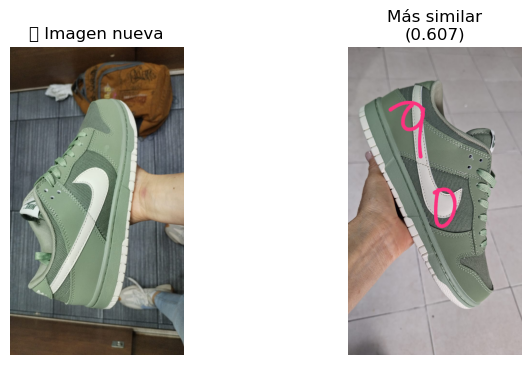

⚠️ Podría ser el mismo, pero con diferencias.


In [17]:
# =====================================================
# 5. USO DEL PROGRAMA (versión con selector de archivo)
# =====================================================
from tkinter import Tk, filedialog

def seleccionar_y_identificar(alpha=0.8):
    """Abre un cuadro de diálogo para seleccionar una imagen y la analiza."""
    root = Tk()
    root.withdraw()  # Oculta la ventana principal de Tkinter
    root.call('wm', 'attributes', '.', '-topmost', True)  # Trae el cuadro al frente

    file_path = filedialog.askopenfilename(
        title="Selecciona una imagen para analizar",
        filetypes=[("Archivos de imagen", "*.jpg *.jpeg *.png")]
    )
    
    if not file_path:
        print("❌ No se seleccionó ninguna imagen.")
        return
    
    print(f"🔍 Analizando: {os.path.basename(file_path)}")
    identificar_tenis(file_path, alpha)

# =====================================================
# 6. EJECUCIÓN
# =====================================================
# Simplemente ejecuta esta línea para abrir el selector:
# Puedes ajustar alpha (0.5 a 1.0) según cuánto peso darle al color.
seleccionar_y_identificar(alpha=0.8)


## Para cinco estilos

C:\Users\hp\AppData\Local\Temp\ipykernel_22084\3358251764.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


✅ Procesadas 55 imágenes para AF1
✅ Procesadas 49 imágenes para EQ
✅ Procesadas 50 imágenes para nike_SB
✅ Procesadas 62 imágenes para samba
✅ Procesadas 60 imágenes para TN

✅ Vectores promedio creados para todos los tenis.

🆕 Analizando: IMG-20250329-WA0045.jpg


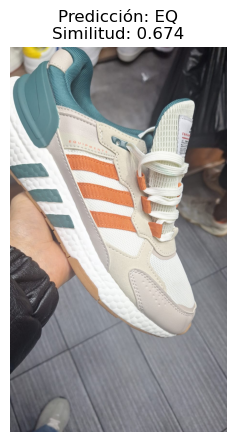

🔍 Resultados de similitud:
 - EQ: 0.674
 - samba: 0.652
 - AF1: 0.591
 - TN: 0.589
 - nike_SB: 0.586


In [18]:
# =====================================================
# CLASIFICADOR DE TENIS POR ESTILO (5 carpetas)
# =====================================================

import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog

# =====================================================
# 1. CONFIGURACIÓN
# =====================================================

dataset_dir = "tenis_dataset"  # Carpeta principal que contiene las 5 subcarpetas
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# =====================================================
# 2. FUNCIONES
# =====================================================

def extraer_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean_color = img.mean(axis=(0,1))
    return mean_color

# =====================================================
# 3. CALCULAR VECTOR PROMEDIO PARA CADA TENIS
# =====================================================

tenis_features = {}
tenis_colors = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    feats, cols = [], []
    for fname in os.listdir(class_path):
        if fname.lower().endswith(".jpg"):
            path = os.path.join(class_path, fname)
            feats.append(extraer_features(path))
            cols.append(promedio_color(path))
    
    feats = np.array(feats)
    cols = np.array(cols)
    tenis_features[class_name] = feats.mean(axis=0)
    tenis_colors[class_name] = cols.mean(axis=0)
    print(f"✅ Procesadas {len(feats)} imágenes para {class_name}")

# Guardar
np.save("tenis_features.npy", tenis_features)
np.save("tenis_colors.npy", tenis_colors)
print("\n✅ Vectores promedio creados para todos los tenis.\n")

# =====================================================
# 4. CLASIFICAR UNA IMAGEN NUEVA
# =====================================================

def clasificar_tenis(imagen_nueva, alpha=0.8):
    tenis_features = np.load("tenis_features.npy", allow_pickle=True).item()
    tenis_colors = np.load("tenis_colors.npy", allow_pickle=True).item()

    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)

    resultados = []

    for nombre, feat_avg in tenis_features.items():
        color_avg = tenis_colors[nombre]
        
        sim_forma = cosine_similarity([feat_new], [feat_avg])[0][0]
        dist_color = np.linalg.norm(color_avg - color_new)
        sim_color = 1 / (1 + dist_color)
        
        sim_total = alpha * sim_forma + (1 - alpha) * sim_color
        resultados.append((nombre, sim_total))
    
    resultados.sort(key=lambda x: x[1], reverse=True)
    mejor = resultados[0]

    # Mostrar resultado visual
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(imagen_nueva))
    plt.title(f"Predicción: {mejor[0]}\nSimilitud: {mejor[1]:.3f}")
    plt.axis('off')
    plt.show()

    print("🔍 Resultados de similitud:")
    for nombre, sim in resultados:
        print(f" - {nombre}: {sim:.3f}")

# =====================================================
# 5. SELECCIONAR IMAGEN DESDE EXPLORADOR
# =====================================================

def seleccionar_y_clasificar(alpha=0.8):
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    file_path = filedialog.askopenfilename(
        title="Selecciona una imagen para clasificar",
        filetypes=[("Archivos de imagen", "*.jpg *.jpeg *.png")]
    )
    if not file_path:
        print("❌ No se seleccionó ninguna imagen.")
        return
    
    print(f"🆕 Analizando: {os.path.basename(file_path)}")
    clasificar_tenis(file_path, alpha)

# =====================================================
# 6. EJECUCIÓN
# =====================================================
# Ejecuta esta línea para abrir el explorador y clasificar una imagen
seleccionar_y_clasificar(alpha=0.8)


🆕 Analizando: IMG-20250404-WA0020.jpg


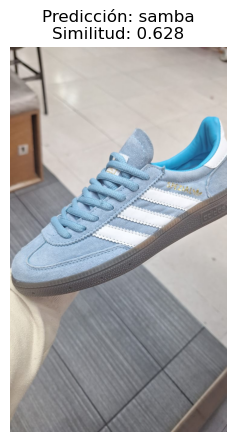

🔍 Resultados de similitud:
 - samba: 0.628
 - AF1: 0.606
 - nike_SB: 0.603
 - EQ: 0.591
 - TN: 0.550


In [22]:
seleccionar_y_clasificar(alpha=0.8)